# Estimación de ICI mediante histogramas de diagramas de constelación

## Librerías

In [1]:
import json
import os
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import sofa
import tensorflow.keras as ker
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, models, regularizers, utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

2023-12-14 11:50:11.774140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Funciones globales

### Extraer datos y calcular los histogramas

In [90]:
# Special function to read the known data structure
def read_data(folder_rx):
    data = {}
    # Read root directory
    for folder in os.listdir(folder_rx):
        # Check name consistency for subdirectories
        if folder.endswith("spacing"):
            # Extract "pretty" part of the name
            spacing = folder[:-8]
            data[spacing] = {}
            # Read each data file
            for file in os.listdir(f"{folder_rx}/{folder}"):
                # Check name consistency for data files
                if file.find("consY") != -1:
                    # Extract "pretty" part of the name
                    osnr = file.split("_")[2][5:-4]
                    # Initialize if not created yet
                    if data[spacing].get(osnr) == None:
                        data[spacing][osnr] = {}
                    # Set data
                    csv_file_data = pl.read_csv(f"{folder_rx}/{folder}/{file}")
                    data[spacing][osnr] = csv_file_data
    return data


def split(a, n):
    k, m = divmod(len(a), n)
    return np.array(
        [a[i * k + min(i, m) : (i + 1) * k + min(i + 1, m)] for i in range(n)]
    )


def plot_constellation_diagram(X, ax):
    ax.scatter(X.real, X.imag, alpha=0.5)
    ax.set_title("Constellation diagram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")


def calculate_gmm(data, gm_kwargs):
    return GaussianMixture(**gm_kwargs).fit(data)


def calculate_1d_histogram(X, bins):
    hist_y, hist_x = np.histogram(X.real, bins=bins)
    # Remove last bin edge
    hist_x = hist_x[:-1]

    return hist_x, hist_y


def plot_1d_histogram(X, bins=128, ax=None):
    ax.hist(X, bins=bins, density=True, alpha=0.5, label="Calculated histogram")


def plot_gmm_1d(gm, limits, ax):
    x = np.linspace(*limits, 1000)

    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.plot(x, pdf_individual, "--", label="Adjusted histogram")


def plot_gmm_2d(gm, limits, ax):
    x = y = np.linspace(*limits)
    X, Y = np.meshgrid(x, y)
    Z = -gm.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    ax.contour(
        X,
        Y,
        Z,
        norm=LogNorm(vmin=1.0, vmax=1000.0),
        levels=np.logspace(0, 3, 25),
        cmap="seismic",
    )


def calculate_3d_histogram(X, bins, limits, spacing, snr):
    hist, xedges, yedges = np.histogram2d(
        X.real, X.imag, bins=bins, range=[[*limits], [*limits]]
    )
    # Define the extent
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Create the meshgrid for the surface plot, excluding the last edge
    x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1])
    return hist, x_mesh, y_mesh


def plot_3d_histogram(x_mesh, y_mesh, hist, ax):
    ax.plot_surface(
        x_mesh, y_mesh, hist.T, cmap="seismic", rstride=1, cstride=1, edgecolor="none"
    )
    ax.set_title("3D Histogram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")

### Regresor

In [91]:
def calc_once(varname, fn, args):
    """Calculate a variable only once."""
    if varname not in globals():
        return fn(**args)
    return eval(varname)


def estimation_model(
    layers_props_lst: list, loss_fn: ker.losses.Loss, input_dim: int
) -> ker.models.Sequential:
    """Compile a sequential model for regression purposes."""
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(input_dim=input_dim, **layer_props))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    model.compile(loss=loss_fn, optimizer="adam")

    return model


def estimation_crossvalidation(
    X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks
):
    """Crossvalidation of an estimation network."""
    # Scores dict
    scores = {}
    scores["model"] = []
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": [], "prod": []}
    scores["r2"] = {"train": [], "test": [], "prod": []}
    scores["rmse"] = {"train": [], "test": [], "prod": []}

    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        X_prod_kf = sc.transform(X_prod)

        model = estimation_model(layer_props, loss_fn, X_train.shape[1])

        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train,
                y_train,
                epochs=5000,
                batch_size=64,
                callbacks=callbacks,
                verbose=0,
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        loss = loss.history["loss"]

        # Predict using train values
        predictions_train = model.predict(X_train, verbose=0)
        # Predict using test values
        predictions_test = model.predict(X_test_kf, verbose=0)
        # Predict using production values
        predictions_prod = model.predict(X_prod_kf, verbose=0)

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )
        train_data_prod = pl.DataFrame(
            {"ICI": [y_prod], "Predicted ICI": [predictions_prod]}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
        mae_score_prod = mean_absolute_error(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
        r2_score_prod = r2_score(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"]
        )

        # RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"], squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"], squared=False
        )
        rmse_score_prod = mean_squared_error(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"], squared=False
        )

        # Append to lists
        scores["model"].append(model)
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["mae"]["prod"].append(mae_score_prod)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["r2"]["prod"].append(r2_score_prod)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        scores["rmse"]["prod"].append(rmse_score_prod)

    return scores


def test_estimation_model(
    data,
    data_prod,
    n_splits,
    max_neurons,
    activations,
    use_osnr=True,
    loss_fn="mean_absolute_error",
):
    """Test a spectral spacing estimation model with given parameters."""
    n_feat = data.shape[1]
    var_n = n_feat - 1 if use_osnr else n_feat - 2

    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n])
    X_prod = np.array(data_prod[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    y_prod = np.array(data_prod[:, -1])

    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(f"{layer_props}{' + OSNR' if use_osnr else ''}")
    callbacks = [
        EarlyStopping(
            monitor="loss", patience=30, mode="min", restore_best_weights=True
        )
    ]

    return estimation_crossvalidation(
        X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks
    )

### Graficar resultados

In [92]:
def plot_results(x_values, scores, xlabel, log=False, intx=False):
    plt.figure(figsize=(8, 6), layout="constrained")
    plt.scatter(x_values, scores)
    plt.plot(x_values, scores)
    plt.xlabel(xlabel)
    plt.ylabel("MAE")
    if log:
        plt.xscale("log", base=2)
    if intx:
        plt.xticks(x_values)
    plt.grid(True)
    plt.show()

## Restaurar variables

In [93]:
%store -r histograms_hist
%store -r histograms_gmm
histograms = (histograms_hist, histograms_gmm)

## Leer datos

In [161]:
file_tx = "../../../Demodulation/Data/Processed/2x16QAM_16GBd.csv"
folder_rx = "../../../Demodulation/Data/Processed"

# Transmitted data
X_tx = np.array(pl.read_csv(file_tx))
X_txs = split(X_tx, 12)

# Read received data
data = read_data(folder_rx)
data["15GHz"]["40dB"]

I,Q
f64,f64
-2.331011,1.744516
-1.312772,3.336845
-1.013831,-1.688941
0.998378,2.981686
0.708215,2.527684
2.823426,2.451208
-3.033331,1.496628
-0.750759,1.549016
0.884689,0.809855


## Obtener histogramas

In [95]:
def get_histograms():
    spacings = ["15", "15.5", "16", "16.5", "17", "17.6", "18"]

    histograms_hist = defaultdict(lambda: defaultdict(list))
    histograms_gmm = defaultdict(lambda: defaultdict(list))
    bins = 128
    limits = [-5, 5]

    for spacing in spacings:
        X_rx = data[f"{spacing}GHz"]
        for snr in X_rx:
            # Extract data
            X_ch = np.array(X_rx[snr])
            X_ch = X_ch[:, 0] + 1j * X_ch[:, 1]

            X_chs = split(X_ch, 12)

            for n, x_ch in enumerate(X_chs):
                # Calculate 2D GMM
                input_data = np.vstack((x_ch.real, x_ch.imag)).T
                gm_kwargs = {
                    "means_init": np.array(list(product([-3, -1, 1, 3], repeat=2))),
                    "n_components": 16,
                }
                gm_2d = calculate_gmm(input_data, gm_kwargs)

                # Calculate 3D histogram
                hist, x_mesh, y_mesh = calculate_3d_histogram(
                    x_ch, bins, limits, spacing, snr
                )

                # Save 3D histogram
                histograms_hist[f"{spacing}GHz"][snr].append(hist)

                # Calculate I and Q histograms
                hist_x, hist_y = calculate_1d_histogram(x_ch.real, bins)
                input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
                gm_kwargs = {
                    "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
                    "n_components": 4,
                }
                gm_i = calculate_gmm(input_data, gm_kwargs)

                # Q
                hist_x, hist_y = calculate_1d_histogram(x_ch.imag, bins)
                input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
                gm_kwargs = {
                    "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
                    "n_components": 4,
                }
                gm_q = calculate_gmm(input_data, gm_kwargs)

                # Save gaussians
                histograms_gmm[f"{spacing}GHz"][snr].append([gm_2d, gm_i, gm_q])

    histograms_hist = dict(histograms_hist)
    histograms_gmm = dict(histograms_gmm)
    return histograms_hist, histograms_gmm


histograms = calc_once("histograms", get_histograms, {})
histograms_hist, histograms_gmm = histograms
%store histograms_hist
%store histograms_gmm

Stored 'histograms_hist' (dict)
Stored 'histograms_gmm' (dict)


In [129]:
def plot_histograms(
    data, histograms_gmm, spacing: None | str = None, osnr: None | str = None
):
    def plot(data, histograms_gmm, osnr, spacing):
        # Extract data
        X_ch = np.array(data[spacing][osnr])
        X_ch = X_ch[:, 0] + 1j * X_ch[:, 1]

        plt.figure(figsize=(12, 12), layout="tight")

        # Plot constellation diagram
        ax = plt.subplot(2, 2, 1)
        plot_constellation_diagram(X_ch, ax)

        gm_2d = histograms_gmm.get(spacing).get(osnr)[0][0]

        # Plot 2D GMM
        plot_gmm_2d(gm_2d, limits, ax)
        ax.grid(True)

        # Calculate 3D histogram
        hist, x_mesh, y_mesh = calculate_3d_histogram(X_ch, bins, limits, spacing, osnr)

        # Plot 3D histogram
        ax = plt.subplot(2, 2, 2, projection="3d")
        plot_3d_histogram(x_mesh, y_mesh, hist, ax)

        # Plot I and Q histograms separately
        # I
        ax = plt.subplot(2, 2, 3)
        plot_1d_histogram(X_ch.real, bins=bins, ax=ax)

        hist_x, hist_y = calculate_1d_histogram(X_ch.real, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
            "n_components": 4,
        }
        gm_i = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_i, limits, ax)

        ax.set_title("I-Histogram")
        ax.set_xlabel("I")
        ax.grid(True)

        # Q
        ax = plt.subplot(2, 2, 4)
        plot_1d_histogram(X_ch.imag, bins=bins, ax=ax)

        hist_x, hist_y = calculate_1d_histogram(X_ch.imag, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
            "n_components": 4,
        }
        gm_q = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_q, limits, ax)
        ax.set_title("Q-Histogram")
        ax.set_xlabel("Q")
        ax.grid(True)

        plt.suptitle(f"Plots for {osnr} OSNR and {spacing} of spacing")

        plt.show()

    bins = 128
    limits = [-5, 5]

    if spacing is not None and osnr is not None:
        plot(data, histograms_gmm, osnr, spacing)

    elif spacing is None and osnr is None:
        spacings = [f"{x}GHz" for x in ["15", "15.5", "16", "16.5", "17", "17.6", "18"]]
        for spacing in spacings:
            for osnr in data[f"{spacing}GHz"]:
                plot(data, histograms_gmm, osnr, spacing)
    else:
        raise ValueError

## Visualizar histogramas y GMM

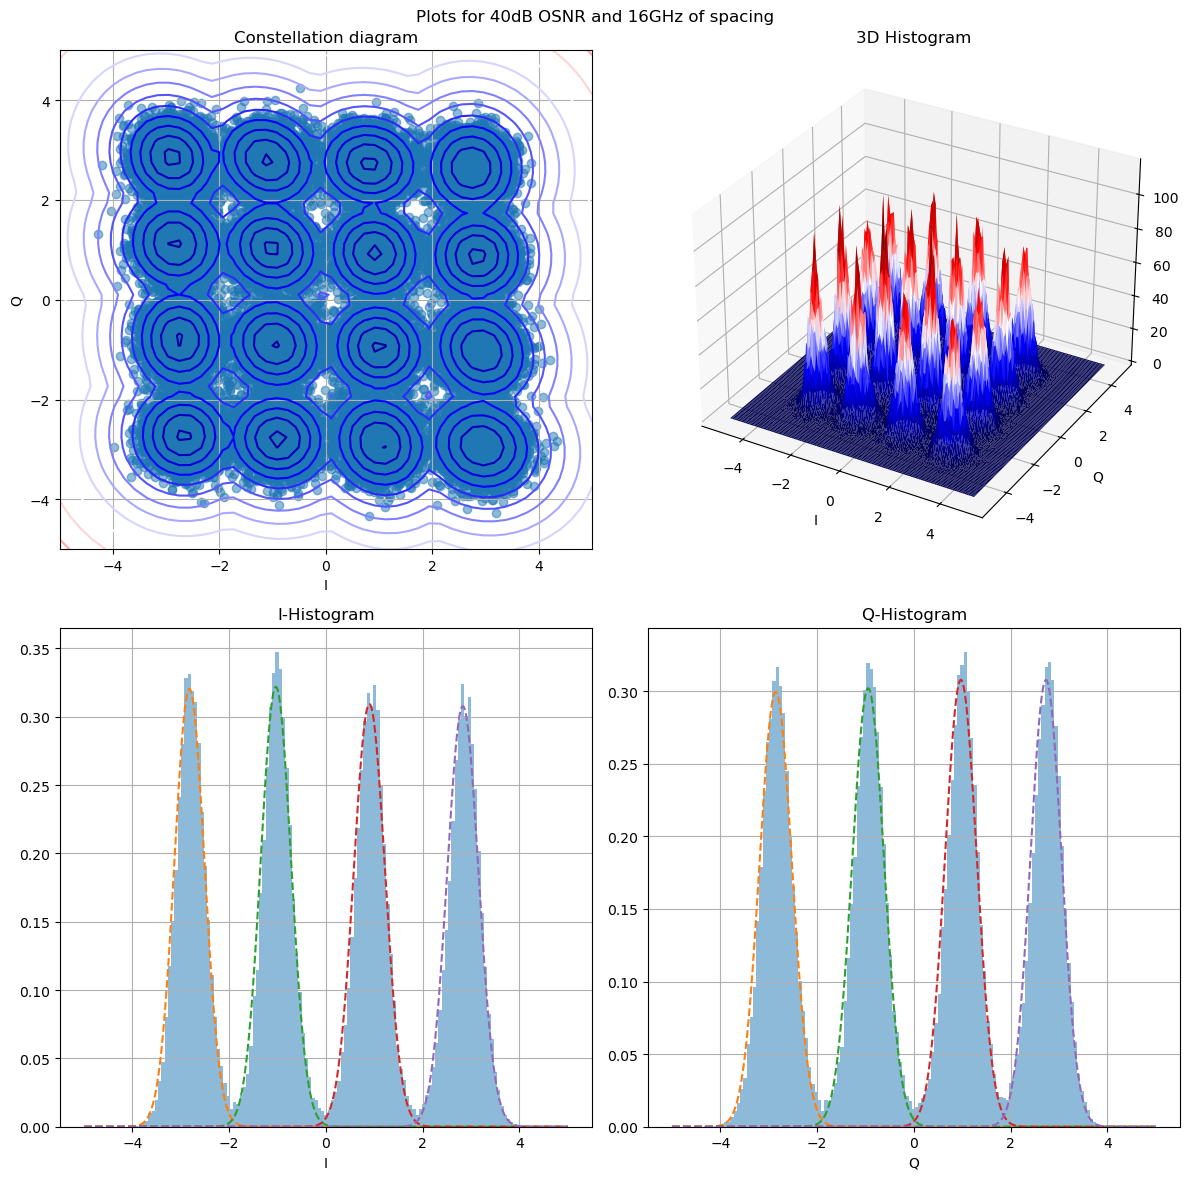

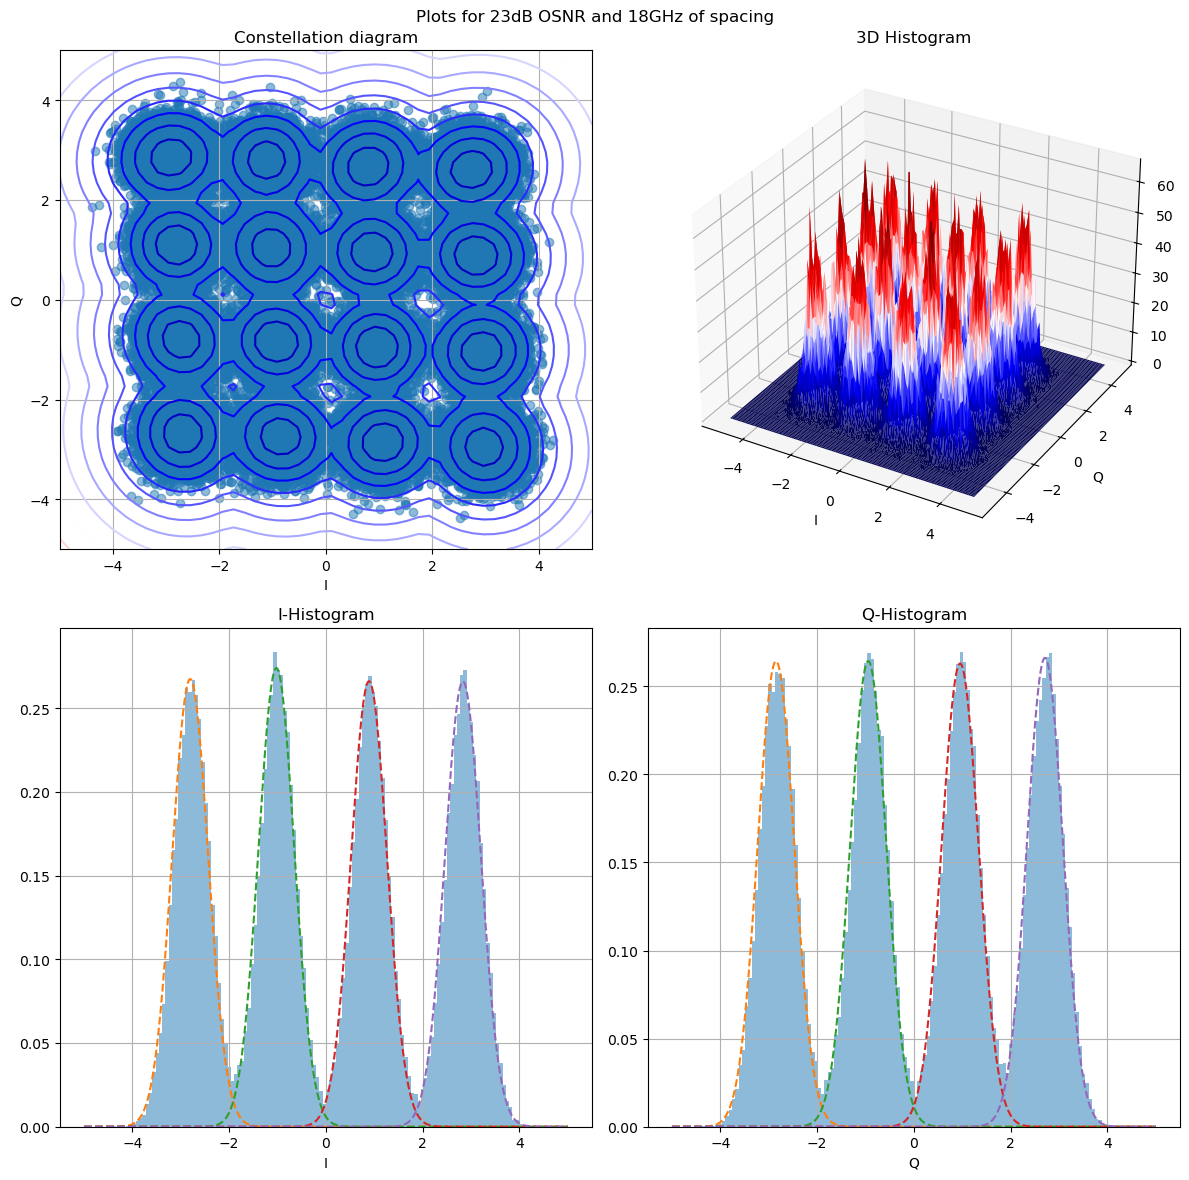

In [164]:
# Spacings: 15, 15.5, 16, 16.5, 17, 17.6, 18 [GHz]
# OSNR: 18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40 [dB]
plot_histograms(data, histograms_gmm, "16GHz", "40dB")
plot_histograms(data, histograms_gmm, "18GHz", "23dB")

In [169]:
histograms_gmm["18GHz"]["18dB"][0][0].covariances_

array([[[ 0.26118218, -0.02089202],
        [-0.02089202,  0.31728489]],

       [[ 0.30183276,  0.00122389],
        [ 0.00122389,  0.41647291]],

       [[ 0.3275331 , -0.0511218 ],
        [-0.0511218 ,  0.32867487]],

       [[ 0.30102375, -0.02343042],
        [-0.02343042,  0.31158261]],

       [[ 0.39230063, -0.01231105],
        [-0.01231105,  0.25650353]],

       [[ 0.38384996, -0.03177218],
        [-0.03177218,  0.33492845]],

       [[ 0.36539381, -0.022606  ],
        [-0.022606  ,  0.3630947 ]],

       [[ 0.3257949 , -0.02637686],
        [-0.02637686,  0.3343146 ]],

       [[ 0.30582815, -0.01646461],
        [-0.01646461,  0.27069133]],

       [[ 0.37691825, -0.00490656],
        [-0.00490656,  0.34205025]],

       [[ 0.35982479,  0.03916344],
        [ 0.03916344,  0.35129718]],

       [[ 0.37401852,  0.02084365],
        [ 0.02084365,  0.28126512]],

       [[ 0.31471932, -0.00370852],
        [-0.00370852,  0.28634801]],

       [[ 0.31593332, -0.0222449 ],
  

## Preparar datos

In [136]:
# Dataframe con 98 columnas
# 16 primeras para las medias
# 64 siguientes para los valores de las matrices de covarianza
# (se incluyen las covarianzas repetidas)
# Penúltima para el valor del OSNR (dB)
# Última para el valor del espaciamiento (GHz)

n_features = 82
df_dict = {f"col{n}": [] for n in range(n_features)}
data_list = []

# Iterate over the dictionary and populate the DataFrame
for spacing, osnr_dict in histograms_gmm.items():
    for osnr, gmm_list in osnr_dict.items():
        for n in range(12):
            gmm_2d = gmm_list[n][0]
            means = gmm_2d.means_.flatten()
            covariances_raw = gmm_2d.covariances_.flatten()
            # Remove repeated covariances
            covariances = []
            for x, covariance in enumerate(covariances_raw):
                if x % 4 != 1:
                    covariances.append(covariance)
            osnr_value = np.array([float(osnr[:-2])])
            spacing_value = np.array([float(spacing[:-3])])

            features = np.concatenate((means, covariances, osnr_value, spacing_value))
            row_dict = {f"col{n}": feature for n, feature in enumerate(features)}
            data_list.append(row_dict)

# Convert the list of dictionaries into a DataFrame
df = pl.DataFrame(data_list)

# Print the DataFrame
df.write_json("histograms_features.json")

In [137]:
# Show the original dataframe
print(df)

shape: (840, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.652703 ┆ -2.715434 ┆ -2.743864 ┆ -0.87217  ┆ … ┆ -0.001191 ┆ 0.26053  ┆ 27.0  ┆ 15.0  │
│ -2.681924 ┆ -2.680687 ┆ -2.764008 ┆ -0.837195 ┆ … ┆ -0.007393 ┆ 0.228427 ┆ 27.0  ┆ 15.0  │
│ -2.71799  ┆ -2.721524 ┆ -2.733467 ┆ -0.892541 ┆ … ┆ 0.017799  ┆ 0.20004  ┆ 27.0  ┆ 15.0  │
│ -2.739696 ┆ -2.705656 ┆ -2.756553 ┆ -0.871217 ┆ … ┆ 0.004289  ┆ 0.212579 ┆ 27.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.677378 ┆ -2.698028 ┆ -2.737297 ┆ -0.774238 ┆ … ┆

In [138]:
# Shuffle the dataframe
df_shuffled = df.sample(n=len(df), shuffle=True, seed=1036681523)
print(df_shuffled)

shape: (840, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.683123 ┆ -2.683971 ┆ -2.755955 ┆ -0.776072 ┆ … ┆ -0.003942 ┆ 0.082038 ┆ 27.0  ┆ 17.6  │
│ -2.659031 ┆ -2.683059 ┆ -2.751103 ┆ -0.771429 ┆ … ┆ -0.003347 ┆ 0.063391 ┆ 32.0  ┆ 18.0  │
│ -2.737246 ┆ -2.711776 ┆ -2.765934 ┆ -0.87035  ┆ … ┆ -0.013907 ┆ 0.219249 ┆ 20.0  ┆ 15.5  │
│ -2.736288 ┆ -2.742261 ┆ -2.781108 ┆ -0.924757 ┆ … ┆ 0.004198  ┆ 0.269067 ┆ 25.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.656296 ┆ -2.720137 ┆ -2.719209 ┆ -0.885479 ┆ … ┆

In [139]:
# Extract 10% of the data to use later for "production" testing
df_prod = df_shuffled[: int(len(df_shuffled) * 0.1)]
print(df_prod)

shape: (84, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.683123 ┆ -2.683971 ┆ -2.755955 ┆ -0.776072 ┆ … ┆ -0.003942 ┆ 0.082038 ┆ 27.0  ┆ 17.6  │
│ -2.659031 ┆ -2.683059 ┆ -2.751103 ┆ -0.771429 ┆ … ┆ -0.003347 ┆ 0.063391 ┆ 32.0  ┆ 18.0  │
│ -2.737246 ┆ -2.711776 ┆ -2.765934 ┆ -0.87035  ┆ … ┆ -0.013907 ┆ 0.219249 ┆ 20.0  ┆ 15.5  │
│ -2.736288 ┆ -2.742261 ┆ -2.781108 ┆ -0.924757 ┆ … ┆ 0.004198  ┆ 0.269067 ┆ 25.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.702646 ┆ -2.692262 ┆ -2.688582 ┆ -0.880594 ┆ … ┆ 

In [140]:
# Use the rest of the data for normal testing
df_new = df_shuffled[int(len(df_shuffled) * 0.1) :]
print(df_new)

shape: (756, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.697051 ┆ -2.716371 ┆ -2.769537 ┆ -0.798645 ┆ … ┆ 0.007473  ┆ 0.067726 ┆ 40.0  ┆ 17.0  │
│ -2.668115 ┆ -2.700485 ┆ -2.760273 ┆ -0.877653 ┆ … ┆ -0.009315 ┆ 0.233922 ┆ 21.5  ┆ 15.5  │
│ -2.674566 ┆ -2.685382 ┆ -2.743034 ┆ -0.790142 ┆ … ┆ 0.000805  ┆ 0.096826 ┆ 27.0  ┆ 17.6  │
│ -2.667003 ┆ -2.69604  ┆ -2.777207 ┆ -0.864497 ┆ … ┆ 0.002846  ┆ 0.195307 ┆ 35.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.656296 ┆ -2.720137 ┆ -2.719209 ┆ -0.885479 ┆ … ┆

## Evaluación de hiperparámetros

Se evaluará una combinación de parámetros:
- Número de neuronas máximas por capa (8, 16, 32, 64, 128, 256, 512, 1024).
- Número de capas (1, 2, 3).
- Combinación de funciones de activación (ReLu, tanh, sigmoid).
- El usar o no la OSNR como característica adicional.

Los resultados tendrán la siguiente estructura:
```
{"xyz": {"n_neurons": {"osnr/wo_osnr": results}}}
```
Donde xyz serán las iniciales de las combinaciones de funciones de activación, n_neurons será el número de neuronas máximo, osnr/wo_osnr será la indicación de si se usó o no el OSNR como característica y results será el objeto resultante que contiene todos los resultados.

In [141]:
osnr_lst = ["osnr", "wo_osnr"]
max_neurons = [str(2**n) for n in range(3, 11)]
functs = ["relu", "tanh", "sigmoid"]
layers_n = [1, 2, 3]

combinations = [
    [list(subset) for subset in product(functs, repeat=n)] for n in layers_n
]

hidden_layers = [item for sublist in combinations for item in sublist]

In [142]:
try:
    histograms_reg_results = sofa.load_hdf5("histograms_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    histograms_reg_results = defaultdict(
        defaultdict(defaultdict(defaultdict().copy).copy).copy
    )

# Evaluar
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {
                "data": df_new,
                "data_prod": df_prod,
                "n_splits": 5,
                "max_neurons": int(neurons),
                "activations": activations,
                "use_osnr": True if osnr == "osnr" else False,
            }
            act_fn_name = "".join([s[0] for s in activations])
            if histograms_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [
                    utils.serialize_keras_object(model) for model in results["model"]
                ]
                # Save serialized model for serialization
                histograms_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(histograms_reg_results, "histograms_reg_results.h5")
                print("Results saved!")

## Resultados

In [143]:
def get_avg_score(results, target_value, target="neurons", metric="mae", score="test"):
    mae_lst = []
    for activations in hidden_layers:
        if target == "layers" and len(activations) != target_value:
            continue
        for neurons in max_neurons:
            if target == "neurons" and neurons != target_value:
                continue
            for osnr in osnr_lst:
                if target == "osnr" and osnr != target_value:
                    continue
                act_fn_name = "".join([s[0] for s in activations])
                mae_lst.append(
                    np.mean(results[act_fn_name][neurons][osnr]["mae"]["test"])
                )
    return mae_lst

### Número máximo de neuronas

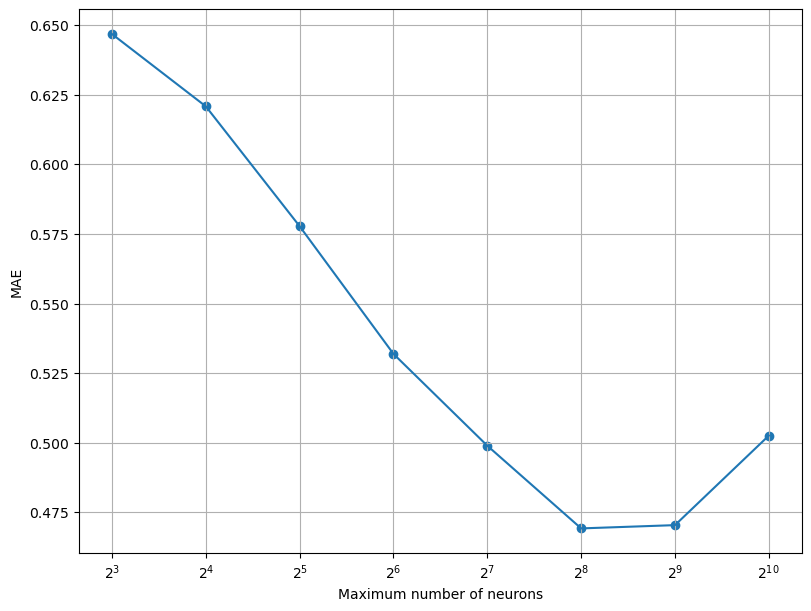

In [144]:
neurons_avg_results = [
    np.mean(
        get_avg_score(
            histograms_reg_results,
            neurons,
            target="neurons",
            metric="mae",
            score="test",
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, neurons_avg_results, "Maximum number of neurons", log=True)

### Número de capas

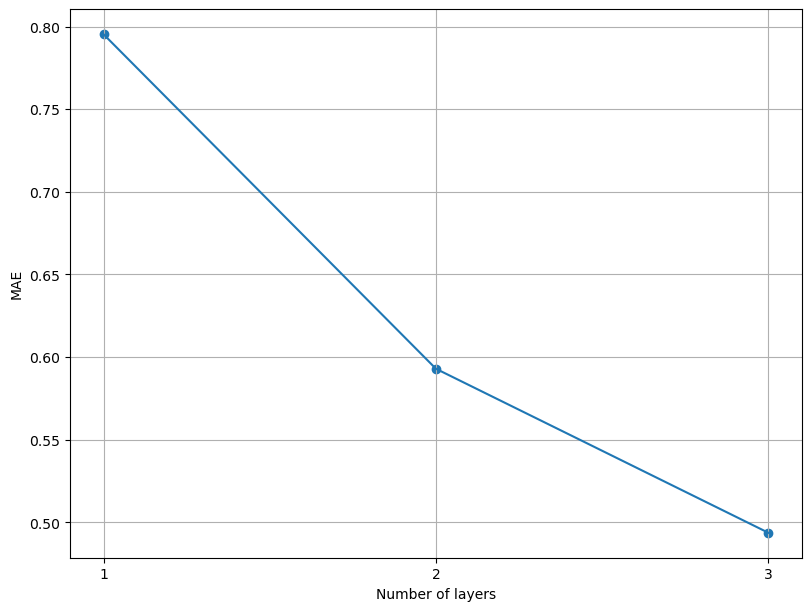

In [145]:
layers_avg_results = [
    np.mean(
        get_avg_score(
            histograms_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, layers_avg_results, "Number of layers", log=False, intx=True)

### OSNR como característica opcional

In [146]:
osnr_avg_results = [
    np.mean(
        get_avg_score(
            histograms_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"Con OSNR  Sin OSNR")
print(f"{osnr_avg_results[0]:.3f}       {osnr_avg_results[1]:.3f}")

Con OSNR  Sin OSNR
0.517       0.562


## Ordenar modelos por puntaje

In [147]:
# Find better model by test score
def get_better_models(results, metric="mae", score="test"):
    scores = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                coll = results[act_fn_name][neurons][osnr][metric][score]
                if isinstance(coll, defaultdict):
                    continue
                score_value = np.mean(coll)
                scores.append((score_value, [act_fn_name, neurons, osnr]))
    scores.sort(key=lambda x: x[0])
    return pl.dataframe.DataFrame(scores)


better_models_df = get_better_models(histograms_reg_results, metric="mae", score="test")
better_models_df.head(10)

column_0,column_1
f64,list[str]
0.277249,"[""tts"", ""512"", ""osnr""]"
0.279191,"[""srt"", ""1024"", ""osnr""]"
0.279408,"[""srt"", ""256"", ""osnr""]"
0.280199,"[""stt"", ""1024"", ""osnr""]"
0.281659,"[""stt"", ""512"", ""osnr""]"
0.283932,"[""ttt"", ""512"", ""osnr""]"
0.28523,"[""st"", ""1024"", ""osnr""]"
0.287078,"[""tss"", ""1024"", ""osnr""]"
0.287834,"[""tss"", ""512"", ""osnr""]"


In [148]:
better_models_df.tail(10)

column_0,column_1
f64,list[str]
1.274483,"[""rrr"", ""128"", ""wo_osnr""]"
1.284129,"[""rrr"", ""1024"", ""osnr""]"
1.285871,"[""rr"", ""1024"", ""osnr""]"
1.290642,"[""rr"", ""256"", ""osnr""]"
1.312181,"[""rr"", ""512"", ""wo_osnr""]"
1.312639,"[""rrr"", ""512"", ""wo_osnr""]"
1.318852,"[""rr"", ""512"", ""osnr""]"
1.330354,"[""rr"", ""256"", ""wo_osnr""]"
1.342281,"[""rrr"", ""1024"", ""wo_osnr""]"
